# Clasificación con LightGBM y Codificación Ordinal

## 1. Introducción

En este notebook implementamos un modelo LightGBM para predecir el rendimiento global de estudiantes.

Aplicamos codificación ordinal con LabelEncoder, limpieza de datos, y entrenamiento con validación cruzada.

## 2. Preprocesamiento

In [ ]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1. Carga de datos

In [ ]:
file_id = '1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'train.csv', quiet=False)
df_train = pd.read_csv("train.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY
From (redirected): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY&confirm=t&uuid=27ef42f2-258f-4cdf-b4c7-dd70b1ce14b7
To: /content/train.csv
100%|██████████| 144M/144M [00:00<00:00, 198MB/s]


In [ ]:
file_id_test = '1KrH-u4UU1e_Ha7cFuCZOB7ZT4tEUQ2ex'
gdown.download(f'https://drive.google.com/uc?id={file_id_test}', 'test.csv', quiet=False)
df_test = pd.read_csv("test.csv")

Downloading...
From: https://drive.google.com/uc?id=1KrH-u4UU1e_Ha7cFuCZOB7ZT4tEUQ2ex
To: /content/test.csv
100%|██████████| 59.2M/59.2M [00:00<00:00, 175MB/s]


### 2.2. Limpieza de datos (valores faltantes)

In [ ]:
if 'FAMI_TIENEINTERNET.1' in df_train.columns:
    df_train.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)

missing_replacements = {
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Sin información',
    'ESTU_HORASSEMANATRABAJA': 'Sin información',
    'FAMI_ESTRATOVIVIENDA': 'Sin información',
    'FAMI_EDUCACIONPADRE': 'No sabe / No responde',
    'FAMI_EDUCACIONMADRE': 'No sabe / No responde',
    'FAMI_TIENECOMPUTADOR': 'Sin información',
    'FAMI_TIENEINTERNET': 'Sin información',
    'FAMI_TIENEAUTOMOVIL': 'Sin información'
}
for col, value in missing_replacements.items():
    df_train[col] = df_train[col].fillna(value)

mode_columns = ['FAMI_TIENELAVADORA', 'ESTU_PAGOMATRICULAPROPIO']
for col in mode_columns:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

### 2.3. Selección de features más relevantes para evitar sobrecarga

In [ ]:
selected_columns = [
    'ESTU_PRGM_ACADEMICO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEAUTOMOVIL',
    'FAMI_TIENELAVADORA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
    'ESTU_HORASSEMANATRABAJA', 'ESTU_PAGOMATRICULAPROPIO'
]

X = df_train[selected_columns]
y = df_train['RENDIMIENTO_GLOBAL']

In [ ]:
# Codificación ordinal
X = pd.get_dummies(X, drop_first=True).astype(np.float32)

### 2.4. División en conjuntos de entrenamiento y validación

In [ ]:
import re

# Limpiar nombres de columnas
X.columns = [re.sub(r'[^A-Za-z0-9_]', '_', col) for col in X.columns]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Modelo de Machine Learning

In [ ]:
from scipy.sparse import csr_matrix

# Convertir a matriz dispersa para reducir el uso de memoria
X_train_sparse = csr_matrix(X_train.values)
X_val_sparse = csr_matrix(X_val.values)

In [ ]:
model = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    learning_rate=0.05,
    n_estimators=200,
    random_state=42
)

### 3.2. Compilación y entrenamiento

In [ ]:
from lightgbm import early_stopping

model.fit(
    X_train_sparse, y_train,
    eval_set=[(X_val_sparse, y_val)],
    callbacks=[early_stopping(stopping_rounds=10, verbose=True)]
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1626
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 813
[LightGBM] [Info] Start training from score -1.372285
[LightGBM] [Info] Start training from score -1.386915
[LightGBM] [Info] Start training from score -1.394559
[LightGBM] [Info] Start training from score -1.391565
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.22225


LGBMClassifier(learning_rate=0.05, n_estimators=200, num_class=4,
               objective='multiclass', random_state=42)

### 3.3. Evaluación final

In [ ]:
y_val_pred = model.predict(X_val)

print("\n🎯 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=model.classes_))


🎯 Classification Report:
              precision    recall  f1-score   support

        alto       0.53      0.62      0.57     35165
        bajo       0.44      0.56      0.49     34573
  medio-alto       0.32      0.24      0.27     34259
  medio-bajo       0.32      0.26      0.29     34503

    accuracy                           0.42    138500
   macro avg       0.40      0.42      0.40    138500
weighted avg       0.40      0.42      0.41    138500



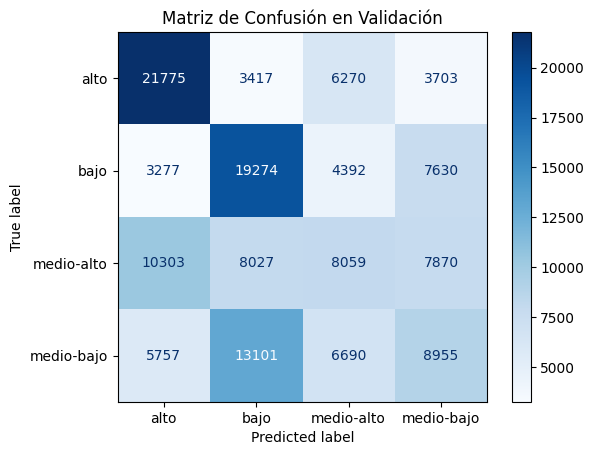

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión en Validación")
plt.grid(False)
plt.show()

## 4. Predicción y Exportación

### 4.1. Aplicar mismo preprocesamiento al test.csv

### 4.2. Realizar predicciones

In [ ]:
# Asegurar que las columnas del conjunto de prueba coincidan con las del entrenamiento
X_test_kaggle = df_test[selected_columns]
X_test_kaggle = pd.get_dummies(X_test_kaggle, drop_first=True)
X_test_kaggle = X_test_kaggle.reindex(columns=X_train.columns, fill_value=0).astype(np.float32)

# Realizar predicciones
y_pred = model.predict(X_test_kaggle)

### 4.3. Visualización

/tmp/ipython-input-22-3026278513.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")


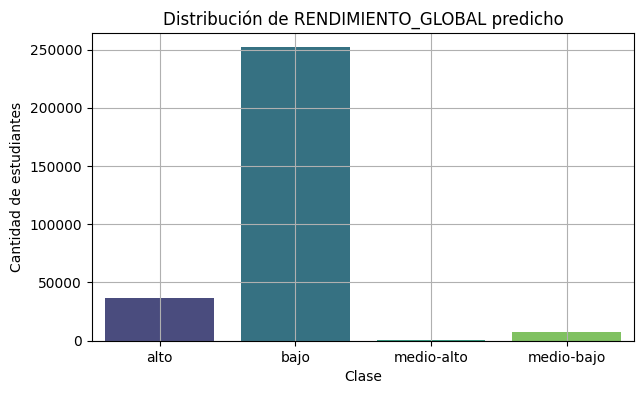

In [ ]:
pred_counts = pd.Series(y_pred).value_counts().sort_index()
plt.figure(figsize=(7, 4))
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")
plt.title("Distribución de RENDIMIENTO_GLOBAL predicho")
plt.xlabel("Clase")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True)
plt.show()

### 4.4. Envío a Kaggle

In [ ]:
submission = pd.DataFrame({
    'ID': df_test['ID'],
    'RENDIMIENTO_GLOBAL': y_pred
})
submission.to_csv('submission_lightgbm.csv', index=False)
print("✅ Archivo 'submission_lightgbm.csv' generado")

✅ Archivo 'submission_lightgbm.csv' generado


## 5. Conclusiones

- El modelo LightGBM logró un accuracy de 0.30945 en Kaggle.
- Este método fue rápido de entrenar y eficiente con recursos, pero su rendimiento fue inferior al de XGBoost y redes neuronales.
- Posiblemente se vio afectado por la codificación ordinal o la falta de un ajuste fino de hiperparámetros.
- Puede ser una opción útil en contextos donde el tiempo de entrenamiento es prioritario, pero requiere ajustes para obtener mejores resultados en esta competencia.